# LeNet

In [1]:
import warnings
warnings.filterwarnings('ignore')  # 不打印 warning 

import tensorflow as tf
import numpy as np
import os

## 加载MNIST数据集

分别加载MNIST训练集、测试集、验证集

In [3]:
from tensorflow.examples.tutorials.mnist import input_data

mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)
X_train, y_train = mnist.train.images, mnist.train.labels
X_test, y_test = mnist.test.images, mnist.test.labels
X_validation, y_validation = mnist.validation.images, mnist.validation.labels

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [4]:
print("Image Shape: {}".format(X_train.shape))
print("label Shape: {}".format(y_train.shape))
print()
print("Training Set:   {} samples".format(len(X_train)))
print("Validation Set: {} samples".format(len(X_validation)))
print("Test Set:       {} samples".format(len(X_test)))

Image Shape: (55000, 784)
label Shape: (55000, 10)

Training Set:   55000 samples
Validation Set: 5000 samples
Test Set:       10000 samples


## 数据处理

由于LeNet的输入为32x32xC，而MNIST每张图像的尺寸为28x28，所以需要对图像四周进行填充，并添加一维，使得每幅图像的形状为32x32x1。

In [5]:
# Pad images with 0s
X_train = np.array([np.pad(X_train[i].reshape((28, 28)), (2, 2), 'constant')[:, :, np.newaxis] for i in range(len(X_train))])
X_validation = np.array([np.pad(X_validation[i].reshape((28, 28)), (2, 2), 'constant')[:, :, np.newaxis] for i in range(len(X_validation))])
X_test = np.array([np.pad(X_test[i].reshape((28, 28)), (2, 2), 'constant')[:, :, np.newaxis] for i in range(len(X_test))])
    
print("Updated Image Shape: {}".format(X_train.shape))

Updated Image Shape: (55000, 32, 32, 1)


## MNIST数据展示

[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]


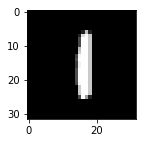

In [6]:
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

index = random.randint(0, len(X_train))
image = X_train[index].squeeze().reshape((32, 32))

plt.figure(figsize=(2,2))
plt.imshow(image, cmap="gray")
print(y_train[index])

## 打乱数据

In [7]:
from sklearn.utils import shuffle

X_train, y_train = shuffle(X_train, y_train)

## LeNet网络结构

![LeNet](https://raw.githubusercontent.com/udacity/CarND-LeNet-Lab/b12183069bcd00bf33bc5c7fd60cd9c4ae2b1bdd/lenet.png)

### Input
  The LeNet architecture accepts a 32x32xC image as input, where C is the number of color channels. Since MNIST images are grayscale, C is 1 in this case.
  LeNet的输入为32x32xC的图像，C为图像的通道数。在MNIST中，图像为灰度图，因此C等于1。

### Architecture
**Layer 1: Convolutional.** 输出为28x28x6的张量。

**Activation.** 激活函数。

**Pooling.** 输出为14x14x6的张量。

**Layer 2: Convolutional.** 输出为10x10x16的张量。

**Activation.** 激活函数。

**Pooling.** 输出为5x5x16的张量。

**Flatten.** 将张量展平为一维向量，使用`tf.contrib.layers.flatten`可以实现。

**Layer 3: Fully Connected.** 输出为120长度的向量。

**Activation.** 激活函数。

**Layer 4: Fully Connected.** 输出为84长度的向量。

**Activation.** 激活函数。

**Layer 5: Fully Connected (Logits).** 输出为10长度的向量。

In [8]:
def conv_layer(x, filter_shape, stride, name):
    with tf.variable_scope(name):
        W = tf.get_variable('weights', shape=filter_shape, initializer=tf.truncated_normal_initializer())
        b = tf.get_variable('biases', shape=filter_shape[-1], initializer=tf.zeros_initializer())
    return tf.nn.conv2d(x, W, strides=stride, padding='VALID', name=name) + b

In [9]:
def max_pool_layer(x, kernel_size, stride, name):
    return tf.nn.max_pool(x, ksize=kernel_size, strides=stride, name=name, padding='VALID')

In [10]:
def fc_layer(x, in_size, out_size, name):
    with tf.variable_scope(name):
        W = tf.get_variable('weights', shape=(in_size, out_size), initializer=tf.truncated_normal_initializer())
        b = tf.get_variable('biases', shape=(out_size), initializer=tf.zeros_initializer())
    
    return tf.nn.xw_plus_b(x, W, b, name=name)

In [11]:
def relu_layer(x, name):
    return tf.nn.relu(x, name=name)

In [12]:
from tensorflow.contrib.layers import flatten

def LeNet(x): 
    conv1 = conv_layer(x, filter_shape=(5, 5, 1, 6), stride=[1, 1, 1, 1], name='conv1')
    relu1 = relu_layer(conv1, 'relu1')
    max_pool1 = max_pool_layer(relu1,  kernel_size=[1, 2, 2, 1], stride=[1, 2, 2, 1], name='max_pool1')
    
    conv2 = conv_layer(max_pool1, filter_shape=(5, 5, 6, 16), stride=[1, 1, 1, 1], name='conv2')
    relu2 = relu_layer(conv2, 'relu2')
    max_pool2 = max_pool_layer(relu2,  kernel_size=[1, 2, 2, 1], stride=[1, 2, 2, 1], name='max_pool1')
    
    flat = flatten(max_pool2)
    
    fc3 = fc_layer(flat, 400, 120, name='fc3')
    relu3 = relu_layer(fc3, 'relu3')
    
    fc4 = fc_layer(relu3, 120, 84, name='fc4')
    relu4 = relu_layer(fc4, 'relu4')
    
    logits = fc_layer(relu4, 84, 10, name='fc5')
    
    return logits

## TensorFlow设置

In [13]:
EPOCHS = 10
BATCH_SIZE = 128
log_dir = './log/'

In [14]:
x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None, 10))

定义损失函数

In [16]:
logits = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(cross_entropy)
train = tf.train.AdamOptimizer(learning_rate=0.01).minimize(loss)

ValueError: Variable conv1/weights already exists, disallowed. Did you mean to set reuse=True or reuse=tf.AUTO_REUSE in VarScope? Originally defined at:

  File "<ipython-input-8-de8ca478d0e2>", line 3, in conv_layer
    W = tf.get_variable('weights', shape=filter_shape, initializer=tf.truncated_normal_initializer())
  File "<ipython-input-12-fbd6aa17dba4>", line 4, in LeNet
    conv1 = conv_layer(x, filter_shape=(5, 5, 1, 6), stride=[1, 1, 1, 1], name='conv1')
  File "<ipython-input-15-dbee436562c3>", line 1, in <module>
    logits = LeNet(x)


## 训练模型

In [17]:
saver = tf.train.Saver()
train_summary_writer = tf.summary.FileWriter(os.path.join(log_dir, 'train'))

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    n_samples = len(X_train)
    
    step = 0
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, n_samples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(train, feed_dict={x: batch_x, y: batch_y})
            
            now_loss = sess.run(loss, feed_dict={x: batch_x, y: batch_y})
            my_summary = tf.Summary(value=[
                tf.Summary.Value(tag="loss", simple_value=now_loss)
            ])
            train_summary_writer.add_summary(my_summary, step)
            train_summary_writer.flush()
            step += 1
            
        print(now_loss)
        
    saver.save(sess, './lenet/')
    print("Model saved")

30.969305
18.862404
3.9557915
8.637002
1.4220576
0.79162097
0.9444689
4.632678e-05
0.12769593
0.41404784
Model saved


loss始终很小

![lenet_tensorboard](./lenet_tensorborad.png)

## 评估模型

In [17]:
correct = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

In [18]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = sess.run(accuracy, feed_dict={x: X_test, y: y_test})
    print("Test Accuracy = {:.3f}".format(test_accuracy))

ValueError: Can't load save_path when it is None.